In [1]:
#Load 
from dotenv import load_dotenv

load_dotenv('keys.env')

True

### Flow Diagram:

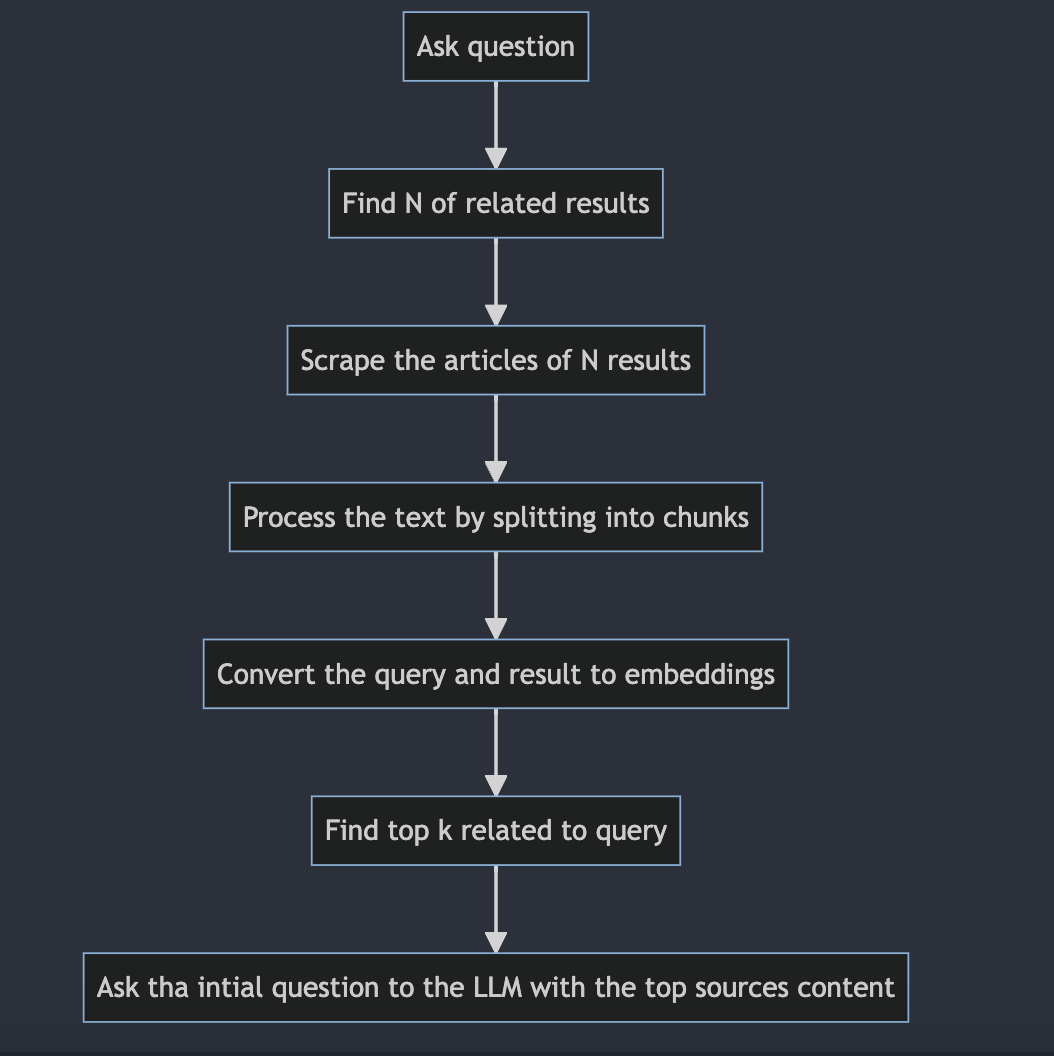

### Ask Trending Questions

In [14]:
from langchain import LLMChain, PromptTemplate
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)

template = """You are an assistant that answers the following question correctly and honestly: {question}\n\n"""
prompt_template = PromptTemplate(input_variables=["question"], template=template)

question_chain = LLMChain(llm=llm, prompt=prompt_template)

question_chain.run("what is the latest christopher nolan movie?")

'\nThe latest Christopher Nolan movie is Tenet, released in 2020.'

 --> Wrong Answer..

In [31]:
from langchain.tools import Tool
from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()
TOP_N_RESULTS = 10

def top_n_results(query):
    return search.results(query, TOP_N_RESULTS)

tool = Tool(
    name = "Google Search",
    description="Search Google for recent results.",
    func=top_n_results
)

query = "What is the last christopher nolan movie released?"

results = tool.run(query)

for result in results:
    print(result["title"])
    print(result["link"])
    print(result["snippet"])
    print("-"*50)

Christopher Nolan filmography - Wikipedia
https://en.wikipedia.org/wiki/Christopher_Nolan_filmography
Three years later he directed the science fiction film Tenet (2020). ... His next feature was Oppenheimer (2023), a biopic centered on J. Robert Oppenheimer, with ...
--------------------------------------------------
Christopher Nolan - IMDb
https://www.imdb.com/name/nm0634240/
In 2008, Nolan directed, co-wrote, and produced The Dark Knight (2008) which went on to gross more than a billion dollars at the worldwide box office. Nolan was ...
--------------------------------------------------
Christopher Nolan movies in order of release
https://www.cineworld.co.uk/static/en/uk/blog/christopher-nolan-movies-in-order-of-release
Jul 10, 2023 ... Christopher Nolan's new movie Oppenheimer is scheduled for a July 2023 release, so here's our blog feature on all his movies in order.
--------------------------------------------------
Everything We Know About Christopher Nolan's Next Movie ...
htt

In [32]:
import newspaper

pages_content = []

for result in results:
	try:
		article = newspaper.Article(result["link"])
		article.download()
		article.parse()
		if len(article.text) > 0:
			pages_content.append({ "url": result["link"], "text": article.text })
	except:
		continue

In [35]:
pages_content[1]

{'url': 'https://www.townandcountrymag.com/leisure/arts-and-culture/a37622562/christopher-nolans-new-movie-robert-oppenheimer-manhattan-project/',
 'text': 'Christopher Nolan\'s last movie Tenet, a mind-bending time travel thriller, took on a larger-than-life meaning thanks to its release in the middle of the COVID-19 pandemic last summer. Because of Nolan\'s outspoken advocacy for movie theaters, he refused to permit a home release for Tenet, which led hyperbolic headlines to declare the movie first as a savior, and later a destroyer, of movie theaters. The legendary writer-director\'s next movie should be able to proceed with less baggage—and the details have now been released.\n\n\n\nHere\'s everything we know about Oppenheimer.\n\nIt tells the story of J. Robert Oppenheimer.\n\nVintage American Prometheus: The Triumph and Tragedy of J. Robert Oppenheimer Vintage American Prometheus: The Triumph and Tragedy of J. Robert Oppenheimer Now 36% Off $16 at Amazon\n\nNolan\'s twelfth movie

In [36]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)

docs = []
for d in pages_content:
	chunks = text_splitter.split_text(d["text"])
	for chunk in chunks:
		new_doc = Document(page_content=chunk, metadata={ "source": d["url"] })
		docs.append(new_doc)

In [37]:
# docs

In [38]:
query

'What is the last christopher nolan movie released?'

In [39]:
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

docs_embeddings = embeddings.embed_documents([doc.page_content for doc in docs])
query_embedding = embeddings.embed_query(query)

In [62]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_indices(list_of_doc_vectors, query_vector, top_k):
  # convert the lists of vectors to numpy arrays
  list_of_doc_vectors = np.array(list_of_doc_vectors)
  query_vector = np.array(query_vector)

  # compute cosine similarities
  similarities = cosine_similarity(query_vector.reshape(1, -1), list_of_doc_vectors).flatten()

  # sort the vectors based on cosine similarity
  sorted_indices = np.argsort(similarities)[::-1]

  # retrieve the top K indices from the sorted list
  top_k_indices = sorted_indices[:top_k]

  return top_k_indices

top_k = 5
best_indexes = get_top_k_indices(docs_embeddings, query_embedding, top_k)
best_k_documents = [doc for i, doc in enumerate(docs) if i in best_indexes]

In [63]:
best_k_documents

[Document(page_content='Nolan will produce the film alongside his wife and longtime co-producer Emma Thomas. More notably, this will be the first film Nolan has made without Warner Bros. in almost two decades, marking the end of the director and studio\'s longtime partnership. Instead, Universal Pictures will finance and distribute the film.\n\nAccording to The Hollywood Reporter, the movie will be a "smaller-scale feature" for Nolan. Universal, Sony, and Apple were all vying for the rights to the film, which came with some very specific stipulations from Nolan, including full creative control, a minimum 100-day theatrical window, and a blackout period where the studio agreed not to release another movie for three weeks before or after the feature. Given Nolan\'s history of both critical and box office success, agreeing to the terms was reportedly a no-brainer for Universal.\n\nThe movie will premiere in summer 2023.\n\nOppenheimer will hit theaters on July 21, 2023.', metadata={'sourc

In [64]:
len(best_k_documents)

5

### Chain with Source

In [67]:
query

'What is the last christopher nolan movie released?'

In [68]:
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.llms import OpenAI

chain = load_qa_with_sources_chain(OpenAI(temperature=0), chain_type="map_reduce")

response = chain({"input_documents": best_k_documents, "question": 'Christopher Nolan 2023 movie'}, return_only_outputs=True)

In [69]:
response

{'output_text': " Christopher Nolan's movie Oppenheimer is set to be released in summer 2023 on July 21.\nSOURCES: \nhttps://www.townandcountrymag.com/leisure/arts-and-culture/a37622562/christopher-nolans-new-movie-robert-oppenheimer-manhattan-project/\nhttps://editorial.rottentomatoes.com/article/everything-we-know-about-christopher-nolans-oppenheimer/\nhttps://www.vulture.com/article/christopher-nolan-movies-ranked.html\nhttps://www.indiewire.com/gallery/oppenheimer-release-date-cast-plot-details/"}

In [70]:
response_text, response_sources = response["output_text"].split("SOURCES:")
response_text = response_text.strip()
response_sources = response_sources.strip()

print(f"Answer: {response_text}")
print(f"Sources: {response_sources}")

Answer: Christopher Nolan's movie Oppenheimer is set to be released in summer 2023 on July 21.
Sources: https://www.townandcountrymag.com/leisure/arts-and-culture/a37622562/christopher-nolans-new-movie-robert-oppenheimer-manhattan-project/
https://editorial.rottentomatoes.com/article/everything-we-know-about-christopher-nolans-oppenheimer/
https://www.vulture.com/article/christopher-nolan-movies-ranked.html
https://www.indiewire.com/gallery/oppenheimer-release-date-cast-plot-details/
